In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import time
%matplotlib inline  
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/jz2308/bus-Capstone')

# these two modules are homemade
import gtfs
import arrivals
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

In [3]:
# get all the schedule data. (subset can be created later)
trips = gtfs.load_trips('2015-12-03','gtfs/')
stops = gtfs.load_stops('2015-12-03','gtfs/')
stop_times, tz_sched = gtfs.load_stop_times('2015-12-03','gtfs/')
tcal=gtfs.TransitCalendar('2015-12-03')
thurs_services = tcal.get_service_ids('2015-12-03')
thurs_trips = trips.service_id.isin(thurs_services)
thurs_stops = stop_times.reset_index().set_index('trip_id').loc[thurs_trips]
print 'Finished loading GTFS data.'

Finished loading GTFS data.


In [4]:
interpolated = pd.read_csv('2015-12-03_interpolated.csv')

In [5]:
interpolated.head()

,route,trip_id,trip_date,vehicle_id,stop_id,interpolated_arrival_time
0,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,402805,0 days 06:10:56.778916
1,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,405057,0 days 06:14:24.977703
2,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,403416,0 days 06:16:58.526210
3,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,402809,0 days 06:17:25.226045
4,MTA NYCT_M101,OH_D5-Weekday-SDon-036500_M101_38,2015-12-03,MTA NYCT_5879,402811,0 days 06:18:36.819142


In [6]:
interpolated['interpolated_arrival_time'] = pd.to_timedelta(interpolated['interpolated_arrival_time'])

In [7]:
interpolated = interpolated.merge(stop_times[['arrival_time','stop_sequence']],how='left',left_on=['trip_id','stop_id'],right_index=True)

In [8]:
# bools = interpolated.duplicated(subset=['route','trip_id','trip_date','vehicle_id','stop_id'],take_last=False) + interpolated.duplicated(subset=['route','trip_id','trip_date','vehicle_id','stop_id'],take_last=True)
# interpolated[bools].sort(['route','trip_id','trip_date','vehicle_id']).shape

In [9]:
interpolated.set_index(['route','trip_id','trip_date','vehicle_id','stop_sequence','stop_id'],inplace=True)

## Get the densest stop_id by shape (trip?)

In [10]:
trip_groups = interpolated.groupby(level=(0,2,5,4)).size()

In [11]:
def series_max(s):
    return s.idxmax()[2]

In [12]:
densest_stops = trip_groups.groupby(level=(0)).apply(series_max)
densest_stops

route
MTA NYCT_B1      300009
MTA NYCT_B11     301173
MTA NYCT_B12     301328
MTA NYCT_B13     301505
MTA NYCT_B14     301598
MTA NYCT_B15     301135
MTA NYCT_B16     301677
MTA NYCT_B17     300853
MTA NYCT_B2      300173
MTA NYCT_B20     301959
MTA NYCT_B24     503993
MTA NYCT_B25     302383
MTA NYCT_B26     302372
MTA NYCT_B3      300261
MTA NYCT_B31     300175
MTA NYCT_B32     302304
MTA NYCT_B35     302692
MTA NYCT_B36     300019
MTA NYCT_B37     302914
MTA NYCT_B38     302948
MTA NYCT_B39     403679
MTA NYCT_B4      300368
MTA NYCT_B41     303295
MTA NYCT_B42     303358
MTA NYCT_B43     303711
MTA NYCT_B44     303483
MTA NYCT_B44+    303441
MTA NYCT_B45     303531
MTA NYCT_B46     303592
MTA NYCT_B47     300857
                  ...  
MTABC_Q50        101743
MTABC_Q52        550070
MTABC_Q53        550070
MTABC_Q60        504399
MTABC_Q64        551812
MTABC_Q65        550032
MTABC_Q66        551894
MTABC_Q67        503832
MTABC_Q69        550010
MTABC_Q70        504542
MTABC_Q72 

## Function that can applied repeatedly

In [13]:
# convert scheduled time to numeric
interpolated['schedule_convert'] = pd.to_timedelta(interpolated['arrival_time'])

In [14]:
def peak_hour(x):
    if x > '06:00:00' and x < '09:00:00':
        return True
    else:
        if x > '16:00:00' and x < '19:00:00':
            return True
        else:
            return False

In [15]:
def wait_ass(x,y):
    if x == True:
        if y >= 3*60:
            return True
        else:
            return False
    if x == False:
        if y>= 5*60:
            return True
        else:
            return False         

In [22]:
def wa_at_stop(route,stop):
    pd.options.mode.chained_assignment = None
    interpolated_2 = interpolated.xs((route,stop),level=(0,5),drop_level=False)
    interpolated_2['sche_headway'] = interpolated_2.sort(columns='schedule_convert')['schedule_convert'].diff()
    interpolated_2['inter_headway'] = interpolated_2.sort(columns='interpolated_arrival_time')['interpolated_arrival_time'].diff()
    interpolated_2['sche_h_sec'] = interpolated_2['sche_headway']/ttools.datetime.timedelta(seconds=1)
    interpolated_2['inter_h_sec'] = interpolated_2['inter_headway']/ttools.datetime.timedelta(seconds=1)
    interpolated_2['P_hour'] = map(lambda x:peak_hour(x),interpolated_2['arrival_time'])
    interpolated_2['diff'] = interpolated_2['inter_h_sec'] - interpolated_2['sche_h_sec']
    interpolated_2['wait_ass'] = map(lambda x,y:wait_ass(x,y), interpolated_2['P_hour'],interpolated_2['diff'])
    ##wait assessment for the single route on the single stop
    # 100% is best
    return 1.0-(1.0*interpolated_2['wait_ass'].sum()/len(interpolated_2['wait_ass']))

In [23]:
wa_at_stop('MTA NYCT_B1',300009)

0.8957055214723927

In [30]:
all_routes = pd.Series(index=densest_stops.index)
for i,v in densest_stops.iteritems():
    all_routes[i] = wa_at_stop(i,v)

In [31]:
all_routes.mean()

0.79945940207255217

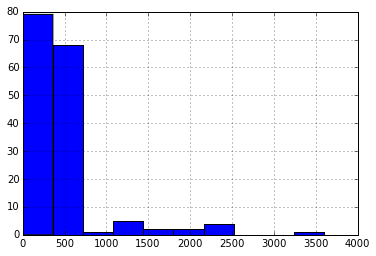

In [21]:
# interpolated_2['sche_h_sec'].hist()

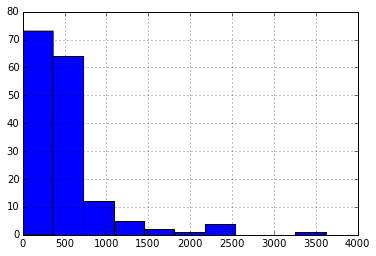

In [22]:
# interpolated_2['inter_h_sec'].hist()

In [24]:
# peak_hour(interpolated_2['arrival_time'][0])

False

In [28]:
# wait_ass(interpolated_2['P_hour'][1],interpolated_2['diff'][1])

True